<a href="https://colab.research.google.com/github/somilasthana/MachineLearningSkills/blob/master/AnomalyDetection_MultiVariate_Gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyarrow

     |████████████████████████████████| 48.5MB 55.5MB/s 


In [0]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
from datetime import datetime
from scipy.stats import multivariate_normal

In [0]:
pdata = pq.ParquetDataset("/content/data/small_supermarket")

In [0]:
table = pdata.read()

In [0]:
data = table.to_pandas()

In [11]:
data.head()

,Basket_Id,Customer_Id,Transaction_Date,Age_Band,Brand,Commodity,Department,Loyalty,Product_Id,Qty,Sales
0,Basket 77054,Customer 24749,2018-06-08,45-54,private,Water - carbonated/flavoured drinks,Grocery,Promiscuous,p834117,1.0,3.99
1,Basket 62442,Customer 16066,2017-12-15,45-54,national,Beef,Meat,Loyalist,p12352352,3.0,8.13
2,Basket 39400,Customer 11274,2017-03-27,45-54,private,Seafood-frozen,Seafood,Promiscuous,p969725,2.0,11.69
3,Basket 77619,Customer 24862,2018-06-14,Greater than 65,national,Oral hygiene products,Pharmaceutical,Loyalist,p892532,1.0,6.39
4,Basket 72556,Customer 26539,2018-04-15,19-24,private,Salad,Deli,Loyalist,p933060,1.0,1.99


In [12]:
data.columns

Index(['Basket_Id', 'Customer_Id', 'Transaction_Date', 'Age_Band', 'Brand',
       'Commodity', 'Department', 'Loyalty', 'Product_Id', 'Qty', 'Sales'],
      dtype='object')

In [0]:
MONTHLY = "%b-%Y"
date_field_name = "Transaction_Date"

In [0]:
class Granularity:
  def __init__(self, gran_value):
    self.gran_value = gran_value
  def __call__(self, d):
    return d.strftime(self.gran_value)

In [0]:
g = Granularity(MONTHLY)

In [0]:
data["Time_Granularity"] = data[date_field_name].apply(g)

In [0]:
data["DateObject"] = pd.to_datetime(data["Time_Granularity"])

In [0]:
data.sort_values(by='DateObject', inplace=True, ascending=True)

In [0]:
data.drop(["DateObject"], axis=1, inplace=True)

In [0]:
data.drop(["Transaction_Date"], axis=1, inplace=True)

In [29]:
data.head()

,Basket_Id,Customer_Id,Age_Band,Brand,Commodity,Department,Loyalty,Product_Id,Qty,Sales,Time_Granularity
420246,Basket 32600,Customer 15506,35-44,national,Deli meats,Deli,Loyalist,p1131321,1.0,3.00,Jan-2017
85559,Basket 34824,Customer 13174,Greater than 65,national,Salad,Deli,First Time Buyer,p1110409,2.0,3.71,Jan-2017
377578,Basket 33545,Customer 10433,55-64,national,Beers/ales,Grocery,Loyalist,p1130729,1.0,7.49,Jan-2017
313329,Basket 34051,Customer 12117,19-24,private,Paper housewares,Grocery,First Time Buyer,p844054,2.0,2.58,Jan-2017
422289,Basket 34817,Customer 12391,25-34,national,Vegetables - all others,Produce,Loyalist,p1018050,1.0,1.99,Jan-2017


In [0]:
segment = ["Age_Band", "Brand", "Commodity", "Department", "Loyalty"]
other_key = ["Basket_Id", "Customer_Id", "Product_Id"]
measure = ["Sales", "Qty"]
time = ["Time_Granularity"]

In [0]:
cause_data = data[["Sales", "Time_Granularity"] + segment]

In [37]:
cause_data.head()

,Sales,Time_Granularity,Age_Band,Brand,Commodity,Department,Loyalty
420246,3.00,Jan-2017,35-44,national,Deli meats,Deli,Loyalist
85559,3.71,Jan-2017,Greater than 65,national,Salad,Deli,First Time Buyer
377578,7.49,Jan-2017,55-64,national,Beers/ales,Grocery,Loyalist
313329,2.58,Jan-2017,19-24,private,Paper housewares,Grocery,First Time Buyer
422289,1.99,Jan-2017,25-34,national,Vegetables - all others,Produce,Loyalist


In [0]:
cause_group = cause_data.pivot_table(index="Time_Granularity", columns="Age_Band",
                                             values="Sales", aggfunc=np.sum)

for key in segment[1:]:
  c = cause_data.pivot_table(index="Time_Granularity", columns=key,
                                             values="Sales", aggfunc=np.sum)
  cause_group = cause_group.join(c)

In [0]:
cause_group.fillna(0, inplace=True)

In [59]:
cause_group.head()

,19-24,25-34,35-44,45-54,55-64,Greater than 65,national,private,Air care,Analgesics,Antacids,Apparel,Apples,Audio/video products,Automotive products,Baby foods,Baby hbc,Bacon,Bag snacks,Baked bread/buns/rolls,Baked sweet goods,Bakery party trays,Baking,Baking mixes,Baking needs,Bath,Bath tissues,Batteries,Beef,Beers/ales,Berries,Beverage,Bird seed,Bleach,Books,Bottle deposits,Bread,Breakfast sausage/sandwiches,Breakfast snacks,Breakfast sweets,...,Stationery/school supplies,Stone fruit,Sugars/sweetners,Suntan,Sushi,Syrup,Syrups/toppings,Teas,Tickets,Tobacco other,Tomatoes,Toys and games,Tropical fruit,Turkey,Valentine,Value added fruit,Value added vegetables,Veal,Vegetables - all others,Vegetables - shelf stable,Vegetables salad,Vitamins,Warehouse snacks,Water,Water - carbonated/flavoured drinks,Yogurt,Cosmetics,Deli,Floral,Grocery,Meat,Nutrition,Pastry,Pharmaceutical,Produce,Salad Bar,Seafood,First Time Buyer,Loyalist,Promiscuous
Time_Granularity,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Apr-2017,3429.00,9018.85,24253.85,30507.61,6897.51,5036.52,65458.28,13685.06,40.24,163.77,39.90,0.00,1058.33,89.91,0.00,281.65,369.14,615.61,596.15,691.45,238.03,0.00,0.00,106.05,74.08,123.30,501.21,83.40,4733.41,461.86,849.14,0.00,0.00,41.71,0.00,0.0,1242.19,681.65,362.35,542.30,...,577.25,861.50,119.08,0.0,74.90,79.90,0.00,57.25,54.60,153.76,561.71,102.13,691.10,257.19,0.00,218.96,179.90,0.00,546.17,228.03,266.01,144.28,68.61,81.60,317.01,318.02,391.26,4035.64,548.10,18401.99,17018.94,2792.73,5137.39,15324.95,12333.50,423.63,2735.21,10723.15,40699.93,27720.26
Apr-2018,3402.51,9530.11,22825.29,27222.77,5429.42,3658.17,58923.34,13144.93,56.32,459.57,104.79,59.94,790.59,199.90,67.66,161.99,287.34,390.81,834.73,694.45,183.85,286.59,14.32,216.09,102.20,113.75,170.64,197.72,4865.58,580.52,747.19,0.00,28.21,15.48,129.20,0.0,659.12,590.34,166.14,871.19,...,438.71,107.33,136.65,0.0,219.90,87.23,0.00,66.37,124.80,2.39,994.03,113.77,558.44,347.32,152.70,301.91,131.65,0.00,688.78,242.62,392.84,862.20,39.84,115.67,205.54,400.42,415.40,4337.79,866.21,18053.17,13402.62,3020.39,4425.90,13522.99,10878.25,582.58,2562.97,6148.55,41532.49,24387.23
Aug-2017,4691.45,16758.82,31527.63,38563.34,8890.90,3477.45,81293.54,22616.05,45.03,388.60,243.52,31.92,825.13,109.89,61.17,227.61,172.46,1225.11,948.90,1034.11,257.18,0.00,86.73,227.13,138.48,117.10,391.26,498.12,8089.83,804.16,974.88,22.50,12.87,12.14,164.39,0.0,1787.02,1839.99,332.17,542.05,...,330.40,0.00,146.08,0.0,53.20,69.71,16.91,91.15,93.60,29.90,818.12,400.06,1004.34,983.95,77.11,115.05,111.81,0.00,864.00,538.52,329.70,394.34,76.40,188.34,406.02,393.75,1207.22,6510.43,805.64,25985.55,23110.76,4294.12,4466.36,17354.69,13524.81,1186.71,5463.30,10320.48,57207.90,36381.21
Dec-2017,4298.13,13391.63,32709.92,43850.80,8474.28,4385.10,82717.31,24392.55,152.78,564.69,324.34,0.00,1188.31,115.87,0.00,163.14,247.26,822.18,850.00,1152.29,507.62,94.81,0.00,327.23,247.51,42.23,488.13,72.51,7060.59,1282.74,1339.67,17.91,0.00,34.64,392.55,0.0,663.37,883.30,577.30,1340.40,...,461.16,421.61,96.60,0.0,208.00,86.82,47.76,77.68,184.15,25.17,777.84,75.35,863.61,434.08,0.00,135.55,315.27,19.92,677.86,411.57,222.38,151.70,126.38,300.65,592.56,557.12,1043.52,7788.84,665.77,32747.84,22802.84,2662.18,5167.21,14986.09,12344.03,653.03,6248.51,11309.49,59272.89,36527.48
Feb-2017,3308.63,9335.10,22422.99,26737.61,4554.11,3555.17,57140.42,12773.19,51.42,335.00,126.83,0.00,754.38,239.88,75.62,156.52,293.85,392.45,706.29,684.68,195.88,216.69,12.53,182.85,138.05,151.65,210.27,215.08,4243.71,542.97,596.05,0.00,17.24,19.02,148.03,0.0,609.46,566.39,167.66,886.26,...,279.16,97.22,161.10,0.0,174.45,97.09,0.00,76.52,156.00,11.95,1011.73,22.40,605.72,256.52,155.18,346.88,122.16,0.00,710.07,210.93,401.75,732.59,50.06,134.56,172.38,400.35,557.61,3916.47,1715.44,17710.75,12290.96,2956.10,4253.22,13264.86,10613.56,535.16,2099.48,9429.46,34432.27,26051.88


Experimenting with Scaling ( Will be Min/Max Scaling because we dont know if each column is normally distributed)

In [0]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

In [0]:
from sklearn import preprocessing

In [0]:
df = cause_group[ ["19-24", "national", "Bath"]]
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=["19-24", "national", "Bath"])

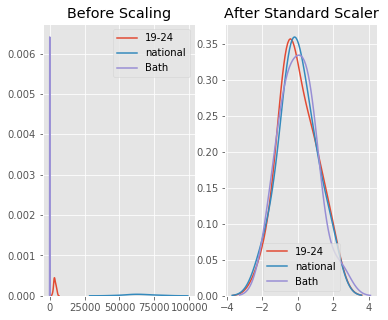

In [67]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(df['19-24'], ax=ax1)
sns.kdeplot(df['national'], ax=ax1)
sns.kdeplot(df['Bath'], ax=ax1)
ax2.set_title('After Standard Scaler')
sns.kdeplot(scaled_df['19-24'], ax=ax2)
sns.kdeplot(scaled_df['national'], ax=ax2)
sns.kdeplot(scaled_df['Bath'], ax=ax2)
plt.show()

In [68]:
scaled_df.head()

,19-24,national,Bath
0,-0.458816,0.103536,0.757463
1,-0.491942,-0.572332,0.574515
2,1.119894,1.741278,0.638690
3,0.628043,1.888530,-0.795585
4,-0.609340,-0.756728,1.300561


In [74]:
scaled_df.sum()

19-24      -4.128642e-15
national    2.997602e-15
Bath        8.881784e-16
dtype: float64

In [0]:
scaled_df = (df - df.min())/ (df.max() - df.min())

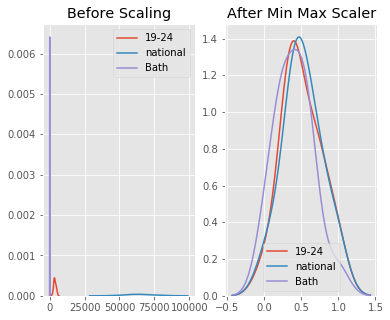

In [70]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(df['19-24'], ax=ax1)
sns.kdeplot(df['national'], ax=ax1)
sns.kdeplot(df['Bath'], ax=ax1)
ax2.set_title('After Min Max Scaler')
sns.kdeplot(scaled_df['19-24'], ax=ax2)
sns.kdeplot(scaled_df['national'], ax=ax2)
sns.kdeplot(scaled_df['Bath'], ax=ax2)
plt.show()

In [75]:
scaled_df.sum()

19-24      -4.128642e-15
national    2.997602e-15
Bath        8.881784e-16
dtype: float64

In [0]:
cause_group["DateObject"] = pd.to_datetime(cause_group.index)
cause_group.sort_values(by='DateObject', inplace=True, ascending=True)
cause_group.drop(["DateObject"], axis=1, inplace=True)

In [150]:
cause_group.head(n=18)

,19-24,25-34,35-44,45-54,55-64,Greater than 65,national,private,Air care,Analgesics,Antacids,Apparel,Apples,Audio/video products,Automotive products,Baby foods,Baby hbc,Bacon,Bag snacks,Baked bread/buns/rolls,Baked sweet goods,Bakery party trays,Baking,Baking mixes,Baking needs,Bath,Bath tissues,Batteries,Beef,Beers/ales,Berries,Beverage,Bird seed,Bleach,Books,Bottle deposits,Bread,Breakfast sausage/sandwiches,Breakfast snacks,Breakfast sweets,...,Stationery/school supplies,Stone fruit,Sugars/sweetners,Suntan,Sushi,Syrup,Syrups/toppings,Teas,Tickets,Tobacco other,Tomatoes,Toys and games,Tropical fruit,Turkey,Valentine,Value added fruit,Value added vegetables,Veal,Vegetables - all others,Vegetables - shelf stable,Vegetables salad,Vitamins,Warehouse snacks,Water,Water - carbonated/flavoured drinks,Yogurt,Cosmetics,Deli,Floral,Grocery,Meat,Nutrition,Pastry,Pharmaceutical,Produce,Salad Bar,Seafood,First Time Buyer,Loyalist,Promiscuous
Time_Granularity,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Jan-2017,2883.70,12368.15,23378.41,29565.51,6447.09,2620.66,60339.45,16924.07,41.87,276.11,200.75,39.90,658.41,139.86,63.91,146.86,118.61,877.90,722.64,787.55,238.80,0.00,106.67,125.96,119.01,48.91,287.94,324.99,6066.23,594.17,731.91,12.50,8.58,12.14,114.06,0.0,1306.02,1565.99,211.74,418.29,...,284.75,0.00,92.06,0.00,53.20,55.81,13.33,56.43,78.00,41.86,665.33,289.51,788.26,713.54,59.78,83.44,96.35,0.00,600.98,398.77,263.31,297.58,56.70,198.56,284.37,288.48,796.95,4954.07,472.93,19145.61,17738.32,3279.68,3485.99,12417.31,9971.53,945.01,4056.12,11153.32,39175.94,26934.26
Feb-2017,3308.63,9335.10,22422.99,26737.61,4554.11,3555.17,57140.42,12773.19,51.42,335.00,126.83,0.00,754.38,239.88,75.62,156.52,293.85,392.45,706.29,684.68,195.88,216.69,12.53,182.85,138.05,151.65,210.27,215.08,4243.71,542.97,596.05,0.00,17.24,19.02,148.03,0.0,609.46,566.39,167.66,886.26,...,279.16,97.22,161.10,0.00,174.45,97.09,0.00,76.52,156.00,11.95,1011.73,22.40,605.72,256.52,155.18,346.88,122.16,0.00,710.07,210.93,401.75,732.59,50.06,134.56,172.38,400.35,557.61,3916.47,1715.44,17710.75,12290.96,2956.10,4253.22,13264.86,10613.56,535.16,2099.48,9429.46,34432.27,26051.88
Mar-2017,4601.17,10143.91,27514.10,25620.11,4728.99,5560.07,63645.71,14522.64,54.63,398.31,264.72,109.89,434.59,119.88,0.00,116.47,302.75,746.88,568.19,719.45,299.01,107.73,211.08,138.02,92.65,79.68,435.36,69.22,7228.34,743.59,1075.82,27.50,3.00,17.50,111.47,0.0,671.48,408.47,230.08,615.23,...,777.80,1146.91,65.99,79.92,84.30,72.96,8.00,68.52,3.12,16.11,720.99,217.69,863.95,166.41,0.00,261.51,146.59,0.00,529.80,224.39,360.38,34.95,74.01,163.23,376.27,323.57,530.30,5139.08,558.35,17663.11,18526.25,3237.53,3162.39,13674.83,12649.15,793.38,2233.98,11230.05,40287.65,26650.65
Apr-2017,3429.00,9018.85,24253.85,30507.61,6897.51,5036.52,65458.28,13685.06,40.24,163.77,39.90,0.00,1058.33,89.91,0.00,281.65,369.14,615.61,596.15,691.45,238.03,0.00,0.00,106.05,74.08,123.30,501.21,83.40,4733.41,461.86,849.14,0.00,0.00,41.71,0.00,0.0,1242.19,681.65,362.35,542.30,...,577.25,861.50,119.08,0.00,74.90,79.90,0.00,57.25,54.60,153.76,561.71,102.13,691.10,257.19,0.00,218.96,179.90,0.00,546.17,228.03,266.01,144.28,68.61,81.60,317.01,318.02,391.26,4035.64,548.10,18401.99,17018.94,2792.73,5137.39,15324.95,12333.50,423.63,2735.21,10723.15,40699.93,27720.26
May-2017,2977.75,9351.92,23201.34,32546.82,6498.59,3570.12,61471.81,16674.73,64.80,536.28,422.74,0.00,1147.08,157.84,0.00,167.96,266.02,475.87,519.71,668.61,241.57,99.80,0.00,227.37,197.66,38.04,259.84,193.05,4034.62,846.34,1190.04,9.95,0.00,35.84,335.61,0.0,569.43,420.66,315.76,1388.48,...,504.00,348.26,53.63,0.00,121.95,49.86,19.90,53.97,130.16,36.84,768.37,322.86,877.78,281.56,0.00,133.74,232.38,14.94,592.04,238.91,206.67,102.80,50.50,287.44,363.81,329.72,798.22,4669.66,721.45,19054.32,13789.48,2669.28,4893.92,15219.98,11762.12,562.61,4005.50,10601.32,41859.50,25685.72
Jun-2017,4221.31,11206.78,31325.41,36759.93,6738.74,3079.03,73029.67,20301

In [0]:
#cause_group_scaled = scaler.fit_transform(cause_group) #(cause_group - cause_group.min()) / (cause_group.max() - cause_group.min())
#cause_group_scaled = pd.DataFrame(cause_group_scaled, columns=list(cause_group))

In [0]:
cause_group_scaled = (cause_group - cause_group.min()) / (cause_group.max() - cause_group.min())

In [168]:
cause_group_scaled.head(n=18)

,19-24,25-34,35-44,45-54,55-64,Greater than 65,national,private,Air care,Analgesics,Antacids,Apparel,Apples,Audio/video products,Automotive products,Baby foods,Baby hbc,Bacon,Bag snacks,Baked bread/buns/rolls,Baked sweet goods,Bakery party trays,Baking,Baking mixes,Baking needs,Bath,Bath tissues,Batteries,Beef,Beers/ales,Berries,Beverage,Bird seed,Bleach,Books,Bottle deposits,Bread,Breakfast sausage/sandwiches,Breakfast snacks,Breakfast sweets,...,Stationery/school supplies,Stone fruit,Sugars/sweetners,Suntan,Sushi,Syrup,Syrups/toppings,Teas,Tickets,Tobacco other,Tomatoes,Toys and games,Tropical fruit,Turkey,Valentine,Value added fruit,Value added vegetables,Veal,Vegetables - all others,Vegetables - shelf stable,Vegetables salad,Vitamins,Warehouse snacks,Water,Water - carbonated/flavoured drinks,Yogurt,Cosmetics,Deli,Floral,Grocery,Meat,Nutrition,Pastry,Pharmaceutical,Produce,Salad Bar,Seafood,First Time Buyer,Loyalist,Promiscuous
Time_Granularity,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Jan-2017,0.213959,0.587452,0.409672,0.369141,0.486257,0.000000,0.408615,0.508545,0.116932,0.268325,0.449197,0.335689,0.319348,0.428342,0.783307,0.461251,0.000000,0.589906,0.600607,0.458682,0.202882,0.000000,0.505353,0.159414,0.140696,0.233918,0.349786,0.512434,0.583001,0.319433,0.298806,0.454545,0.228861,0.205961,0.173954,0.0,0.633686,0.808595,0.110906,0.123799,...,0.198615,0.000000,0.321294,0.00,0.000000,0.407824,0.219894,0.349691,0.423568,0.267562,0.220612,0.707276,0.463247,0.352084,0.333240,0.000000,0.298940,0.00,0.476045,0.625686,0.496900,0.318647,0.156314,0.644521,0.291305,0.282651,0.356209,0.429802,0.027001,0.310967,0.565916,0.599050,0.121440,0.133445,0.308702,0.775805,0.506794,0.849922,0.267663,0.489697
Feb-2017,0.350740,0.302466,0.349231,0.244257,0.088310,0.275788,0.324073,0.235400,0.154267,0.400049,0.265787,0.000000,0.435420,0.785722,0.926829,0.499253,0.603589,0.016536,0.571746,0.306011,0.075614,0.756098,0.059361,0.397010,0.182203,0.725286,0.140641,0.303309,0.207438,0.268829,0.142059,0.000000,0.459856,0.390709,0.225762,0.0,0.103208,0.110316,0.003697,0.486297,...,0.191417,0.076754,0.898503,0.00,0.577244,0.791396,0.000000,0.725979,0.847135,0.076382,0.550806,0.000000,0.203714,0.076100,0.865043,0.526206,0.381593,0.00,0.693360,0.122566,0.923986,0.832758,0.094752,0.421672,0.033780,0.581377,0.202590,0.221094,1.000000,0.238283,0.125778,0.471157,0.333359,0.229769,0.410664,0.395639,0.066623,0.629232,0.094802,0.442760
Mar-2017,0.766799,0.378461,0.671303,0.194907,0.125074,0.867464,0.495990,0.350521,0.166817,0.541660,0.607920,0.924533,0.048645,0.356951,0.000000,0.341699,0.634244,0.435157,0.327973,0.357614,0.381420,0.375903,1.000000,0.209781,0.083232,0.381080,0.746749,0.025782,0.822475,0.467117,0.695587,1.000000,0.080021,0.349893,0.170004,0.0,0.150440,0.000000,0.155511,0.276352,...,0.833432,0.905467,0.103336,1.00,0.148060,0.567181,0.131970,0.576138,0.016943,0.102972,0.273668,0.517105,0.570862,0.021685,0.000000,0.355685,0.459826,0.00,0.334250,0.158618,0.796360,0.008261,0.316800,0.521501,0.502633,0.376352,0.185062,0.467015,0.093893,0.235870,0.629579,0.582390,0.032057,0.276362,0.733941,0.635157,0.096880,0.859745,0.308174,0.474611
Apr-2017,0.389486,0.272751,0.465054,0.410746,0.580945,0.712956,0.543891,0.295405,0.110559,0.017044,0.050096,0.000000,0.803038,0.249866,0.000000,0.991503,0.862915,0.280112,0.377328,0.316058,0.200599,0.000000,0.000000,0.076261,0.042749,0.589698,0.924065,0.052762,0.308350,0.188661,0.434058,0.000000,0.000000,1.000000,0.000000,0.0,0.585075,0.190832,0.477211,0.219860,...,0.575218,0.680141,0.547195,0.00,0.103309,0.631667,0.000000,0.365050,0.296497,0.982806,0.121840,0.211116,0.325106,0.076505,0.000000,0.270694,0.566497,0.00,0.366860,0.168367,0.505229,0.137471,0.266735,0.237265,0.366362,0.361532,0.095820,0.245064,0.085866,0.273299,0.507791,0.406586,0.577579,0.463899,0.683812,0.292186,0.209638,0.794852,0.323197,0.531508
May-2017,0.244232,0.304046,0.398471,0.500800,0.497083,0.280200,0.438540,0.492

In [0]:
m = cause_group_scaled.T.mean()

In [0]:
multivariate_mean = m.to_numpy()

In [171]:
multivariate_mean.shape

(18,)

In [0]:
multivariate_cov = np.cov(cause_group_scaled.to_numpy())

In [173]:
multivariate_cov.shape

(18, 18)

In [0]:
#x = np.random.multivariate_normal(multivariate_mean, multivariate_cov, (18, 18))
x = multivariate_normal(multivariate_mean, multivariate_cov)

In [192]:
x.mean

array([0.33397978, 0.31010749, 0.32227673, 0.32817473, 0.34191121,
       0.44043225, 0.4646529 , 0.5342007 , 0.39065287, 0.38446997,
       0.36335195, 0.55027064, 0.28286082, 0.22961633, 0.33870728,
       0.32060926, 0.29812069, 0.14250074])

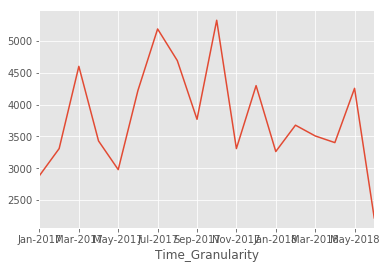

In [162]:
cause_group["19-24"].plot()

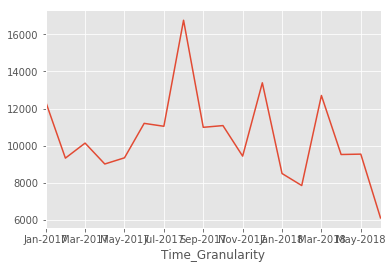

In [163]:
cause_group["25-34"].plot()

In [144]:
cause_data.head()

,Sales,Time_Granularity,Age_Band,Brand,Commodity,Department,Loyalty
420246,3.00,Jan-2017,35-44,national,Deli meats,Deli,Loyalist
85559,3.71,Jan-2017,Greater than 65,national,Salad,Deli,First Time Buyer
377578,7.49,Jan-2017,55-64,national,Beers/ales,Grocery,Loyalist
313329,2.58,Jan-2017,19-24,private,Paper housewares,Grocery,First Time Buyer
422289,1.99,Jan-2017,25-34,national,Vegetables - all others,Produce,Loyalist


In [0]:
sum_sales_group = cause_data.groupby(["Time_Granularity"], sort=False).agg({"Sales": np.sum})

In [146]:
sum_sales_group.head()

,Sales
Time_Granularity,
Jan-2017,77263.52
Feb-2017,69913.61
Mar-2017,78168.35
Apr-2017,79143.34
May-2017,78146.54


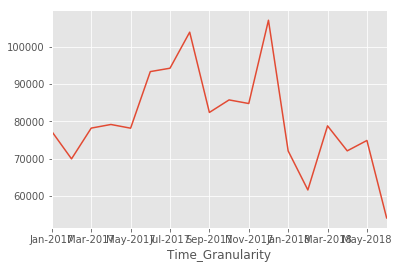

In [147]:
sum_sales_group["Sales"].plot()